In [ ]:
!pip install gradio # Only run once if you don't have gradio installed in the notebook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input, Rescaling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import joblib

import gradio as gr

In [ ]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
!cp -r /content/drive/MyDrive/dataset/training_set /content/training_set
!cp -r /content/drive/MyDrive/dataset/validation_set /content/validation_set

# **Pre-Processing**

In [ ]:
# Initialise directories and labels
patht = '/content/training_set'
pathv = '/content/validation_set'
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
img_size = 224
batch_size = 32

In [ ]:
# Load Dataset with Keras (normal preprocessing crashes colab due to dataset size)
train_ds = tf.keras.utils.image_dataset_from_directory(
    patht,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle = True,
    seed = 42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    pathv,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle = True,
    seed = 42
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 7721 files belonging to 5 classes.
Found 856 files belonging to 5 classes.


In [ ]:
print(len(train_ds))
print(len(val_ds))
num_classes = 5

242
27


# **Classic CNN**

In [ ]:
# Create and Initialise Simple CNN
def create_simple_cnn(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = create_simple_cnn(input_shape=(img_size, img_size, 3), num_classes=len(categories))

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,853 (84.87 MB)

 Trainable params: 22,246,405 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train Model
history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=15)
predictions = cnn_model.predict(val_ds)

Epoch 1/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.5688 - loss: 14.4595 - precision: 0.5956 - recall: 0.5303 - val_accuracy: 0.6764 - val_loss: 1.0652 - val_precision: 0.7706 - val_recall: 0.5456
Epoch 2/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.6368 - loss: 1.0992 - precision: 0.8053 - recall: 0.4876 - val_accuracy: 0.7208 - val_loss: 0.8037 - val_precision: 0.8510 - val_recall: 0.5736
Epoch 3/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.6620 - loss: 0.9384 - precision: 0.8161 - recall: 0.5275 - val_accuracy: 0.7407 - val_loss: 0.7359 - val_precision: 0.8908 - val_recall: 0.6005
Epoch 4/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.7042 - loss: 0.8564 - precision: 0.8347 - recall: 0.5825 - val_accuracy: 0.7956 - val_loss: 0.6111 - val_precision: 0.8664 - val_recall: 0.7196
Epoch 5/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.7198 - loss: 0.7738 - precision: 0.8464 - recall: 0.6109 - val_accuracy: 0.6998 - v

In [ ]:
# Calculate F1 score (macro for multi-class)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_pred_prob = cnn_model.predict(val_ds)
val_pred = np.argmax(val_pred_prob, axis=1)
val_true = np.argmax(val_labels, axis=1)

f1 = f1_score(val_true, val_pred, average='macro')
print(f'Validation F1 Score: {f1:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Validation F1 Score: 0.7199


In [ ]:
model.save('/content/drive/MyDrive/models/art_style_cnn_model.h5')

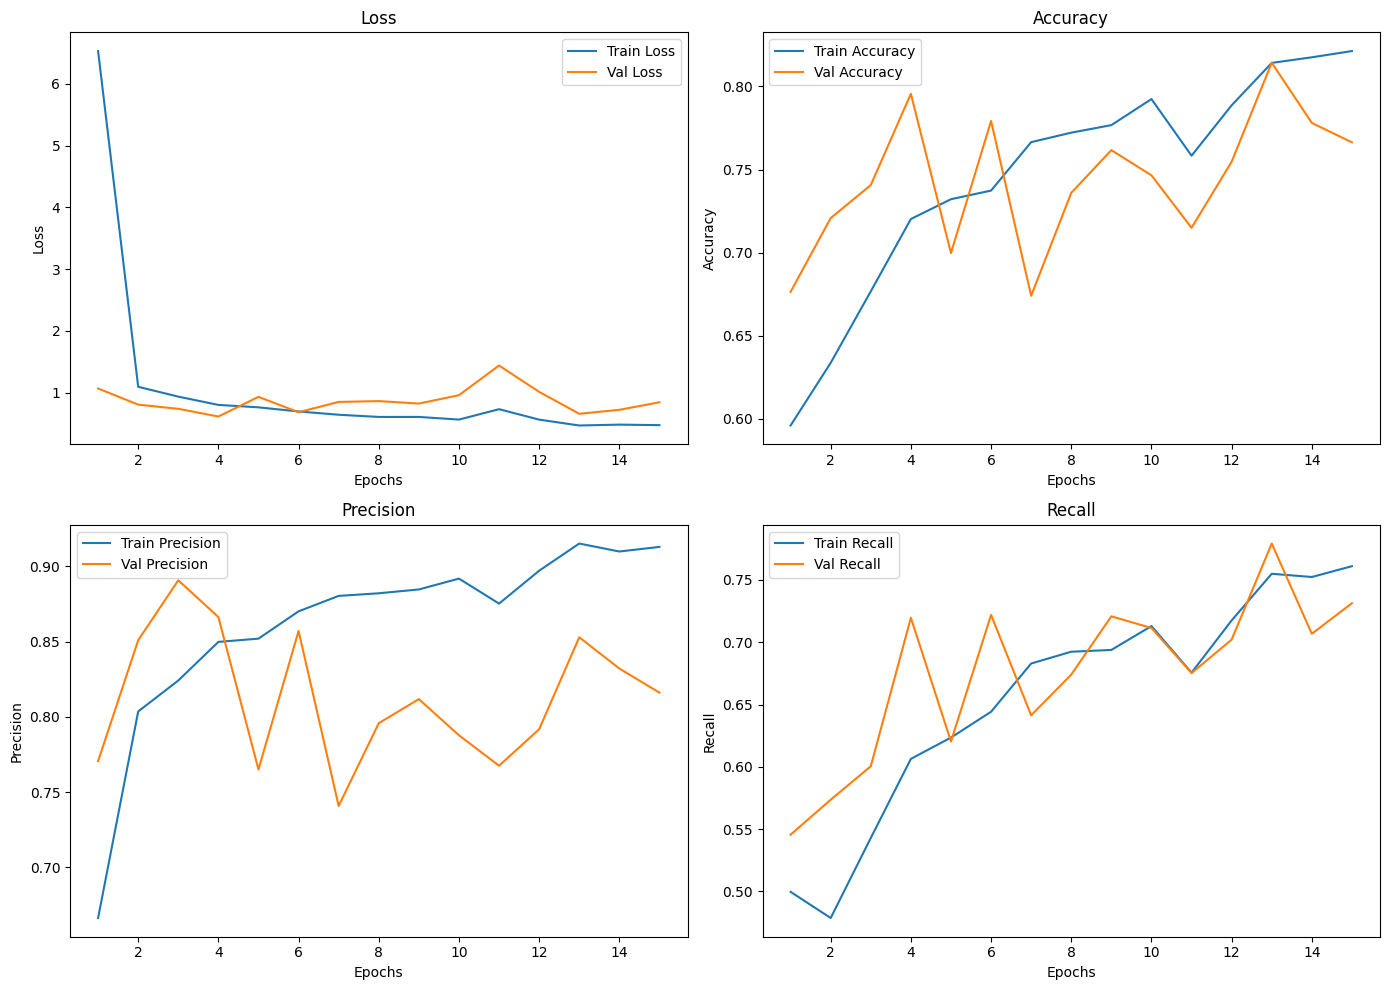

In [ ]:
# Visualize training & validation metrics
def plot_metrics(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['precision'], label='Train Precision')
    plt.plot(epochs, history.history['val_precision'], label='Val Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['recall'], label='Train Recall')
    plt.plot(epochs, history.history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)

<Figure size 800x800 with 0 Axes>

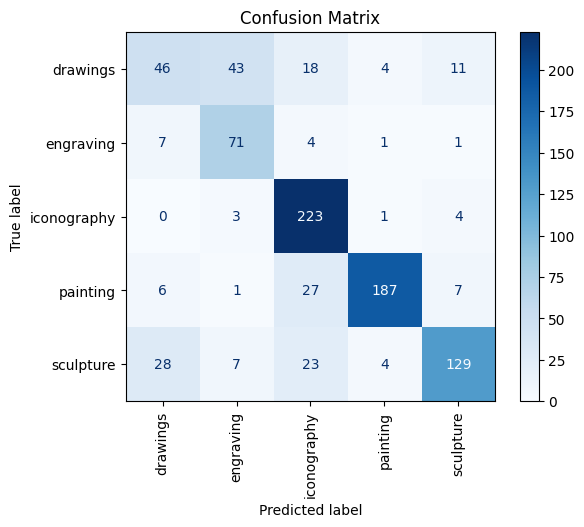

In [ ]:
# Visualize Confusion Matrix
cm = confusion_matrix(val_true, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# **SVM**

In [ ]:
# Simple CNN for feature extraction (different from previous)
def create_feature_extractor(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D()
    ])
    return model

feature_extractor = create_feature_extractor()
feature_extractor.save_weights('/content/drive/MyDrive/models/feature_extractor.weights.h5')

In [ ]:
# Start extracting features and labels in batches
def extract_features(dataset, feature_extractor):
    features_list = []
    labels_list = []

    for i, (images, labels) in enumerate(dataset):
        features_batch = feature_extractor(images).numpy()
        labels_batch = labels.numpy()

        features_list.append(features_batch)
        labels_list.append(labels_batch)

        if i % 10 == 0:
            print(f"Processed {i * images.shape[0]} samples...")

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

X_train, y_train = extract_features(train_ds, feature_extractor)
X_val, y_val = extract_features(val_ds, feature_extractor)

Processed 0 samples...
Processed 320 samples...
Processed 640 samples...
Processed 960 samples...
Processed 1280 samples...
Processed 1600 samples...
Processed 1920 samples...
Processed 2240 samples...
Processed 2560 samples...
Processed 2880 samples...
Processed 3200 samples...
Processed 3520 samples...
Processed 3840 samples...
Processed 4160 samples...
Processed 4480 samples...
Processed 4800 samples...
Processed 5120 samples...
Processed 5440 samples...
Processed 5760 samples...
Processed 6080 samples...
Processed 6400 samples...
Processed 6720 samples...
Processed 7040 samples...
Processed 7360 samples...
Processed 7680 samples...
Processed 0 samples...
Processed 320 samples...
Processed 640 samples...


In [ ]:
# Hot encode the labe;s, fit the model, predict and output report
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train_labels)

y_pred = svm.predict(X_val)
report = classification_report(y_val_labels, y_pred, target_names=categories, digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    drawings     0.6410    0.6148    0.6276       122
   engraving     0.8060    0.6429    0.7152        84
 iconography     0.9076    0.9351    0.9211       231
    painting     0.9234    0.8991    0.9111       228
   sculpture     0.8302    0.9215    0.8734       191

    accuracy                         0.8481       856
   macro avg     0.8216    0.8027    0.8097       856
weighted avg     0.8466    0.8481    0.8458       856



In [ ]:
# Fetch and output metrics
accuracy = accuracy_score(y_val_labels, y_pred)
precision = precision_score(y_val_labels, y_pred, average='macro')
recall = recall_score(y_val_labels, y_pred, average='macro')
f1 = f1_score(y_val_labels, y_pred, average='macro')

print("Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Metrics:
Accuracy : 0.8481
Precision: 0.8216
Recall   : 0.8027
F1-score : 0.8097


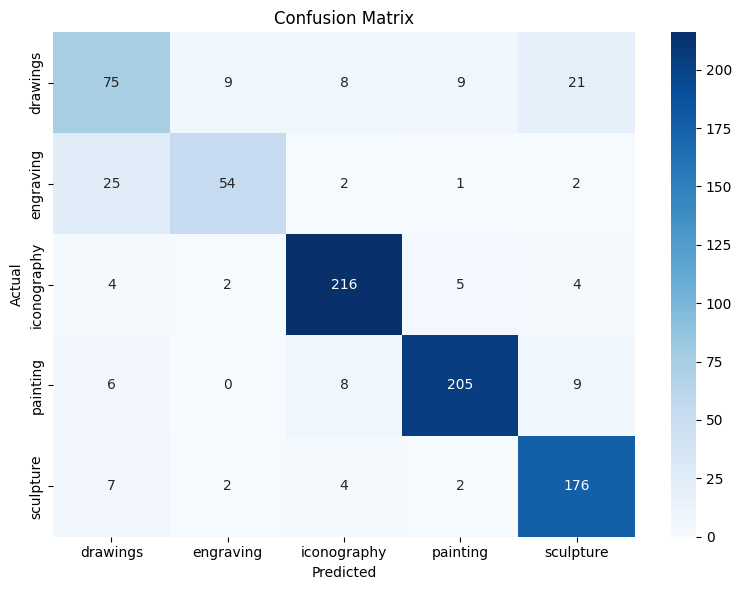

In [ ]:
# Produce and visualise confusion matrix
cm = confusion_matrix(y_val_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/models/svm_model.joblib'
joblib.dump(svm, save_path)

['/content/drive/MyDrive/models/svm_model.joblib']

# **K-Means**

In [ ]:
# Extraxt features for kmeans (without labels)
def extract_features_for_kmeans(dataset, feature_extractor):
    features_list = []

    for i, (images, _) in enumerate(dataset):
        features_batch = feature_extractor(images).numpy()
        features_list.append(features_batch)

        if i % 10 == 0:
            print(f"Processed {i * images.shape[0]} samples...")

    features = np.concatenate(features_list, axis=0)
    return features

X_train_features = extract_features_for_kmeans(train_ds, feature_extractor)
X_val_features = extract_features_for_kmeans(val_ds, feature_extractor)

Processed 0 samples...
Processed 320 samples...
Processed 640 samples...
Processed 960 samples...
Processed 1280 samples...
Processed 1600 samples...
Processed 1920 samples...
Processed 2240 samples...
Processed 2560 samples...
Processed 2880 samples...
Processed 3200 samples...
Processed 3520 samples...
Processed 3840 samples...
Processed 4160 samples...
Processed 4480 samples...
Processed 4800 samples...
Processed 5120 samples...
Processed 5440 samples...
Processed 5760 samples...
Processed 6080 samples...
Processed 6400 samples...
Processed 6720 samples...
Processed 7040 samples...
Processed 7360 samples...
Processed 7680 samples...
Processed 0 samples...
Processed 320 samples...
Processed 640 samples...


In [ ]:
# Elbow method to get optimal k
def elbow_method(X, max_k=10):
    inertias = []
    k_values = range(1, max_k + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        print(f"Fitted k={k}, Inertia={kmeans.inertia_:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (WCSS)')
    plt.grid(True)
    plt.xticks(k_values)
    plt.tight_layout()
    plt.show()

Fitted k=1, Inertia=22676264.00
Fitted k=2, Inertia=8830903.00
Fitted k=3, Inertia=4764525.00
Fitted k=4, Inertia=3630544.75
Fitted k=5, Inertia=2885870.00
Fitted k=6, Inertia=2484494.75
Fitted k=7, Inertia=2245444.75
Fitted k=8, Inertia=2087684.12
Fitted k=9, Inertia=1888385.62
Fitted k=10, Inertia=1753489.38


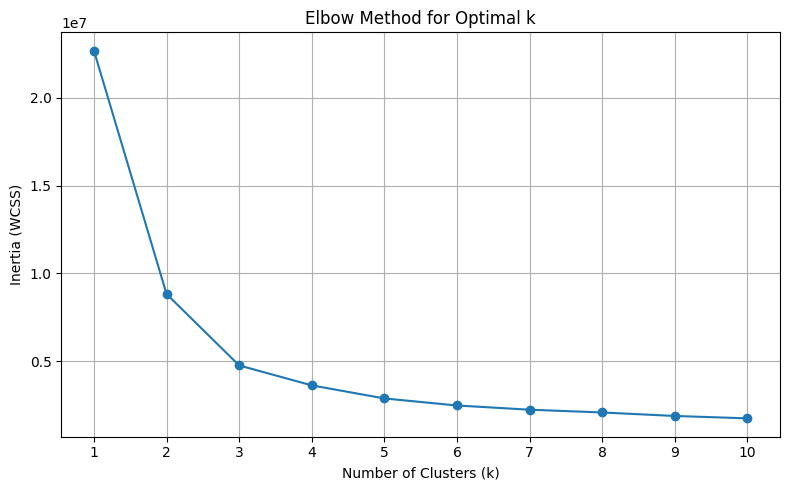

In [ ]:
elbow_method(X_train_features, max_k=10)

In [ ]:
# Fit and predict
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train_features)

train_clusters = kmeans.predict(X_train_features)
val_clusters = kmeans.predict(X_val_features)

In [ ]:
# Calculate silhouette
score = silhouette_score(X_train_features, train_clusters)
print(f"Silhouette Score for k={k}: {score:.4f}")

Silhouette Score for k=3: 0.4664


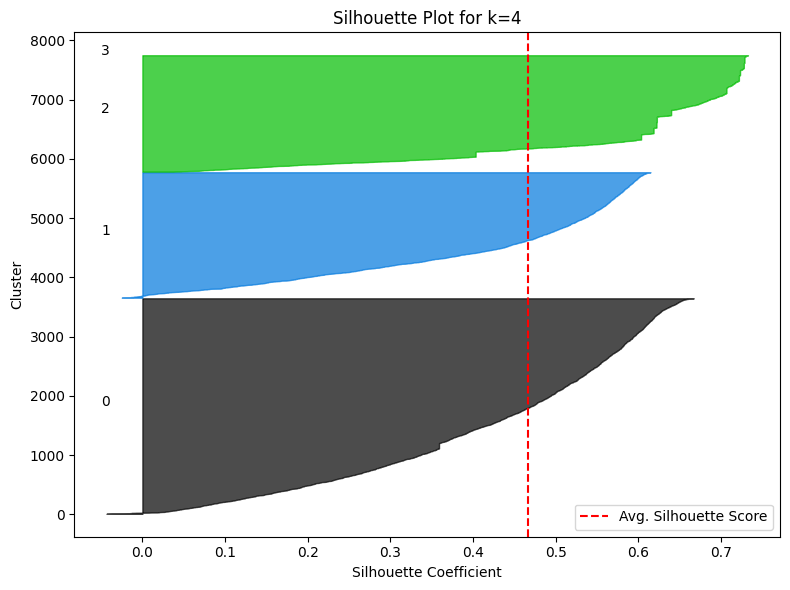

In [ ]:
def plot_silhouette(X, labels, k):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower = 10
    plt.figure(figsize=(8, 6))

    for i in range(k):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--", label="Avg. Silhouette Score")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.title(f"Silhouette Plot for k={k}")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_silhouette(X_train_features, train_clusters, k=4)

In [ ]:
save_path = '/content/drive/MyDrive/models/kmeans_model.joblib'
joblib.dump(kmeans, save_path)

['/content/drive/MyDrive/models/kmeans_model.joblib']

# **GUI**

In [ ]:
# Load model, define class labels and image size
model_cnn = load_model(
    "/content/drive/MyDrive/models/art_style_cnn_model.h5",
    custom_objects={'preprocess_input': preprocess_input}
)
model_kmeans = joblib.load("/content/drive/MyDrive/models/kmeans_model.joblib")
model_svm = joblib.load("/content/drive/MyDrive/models/svm_model.joblib")

feature_extractor = create_feature_extractor(input_shape=(224, 224, 3))
feature_extractor.load_weights('/content/drive/MyDrive/models/feature_extractor.weights.h5')

class_names = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
img_size = 224

In [ ]:
# Preprocess the image and run predictions for each loaded model
def extract_features(img):
    img = img.resize((img_size, img_size))
    img_array = image.img_to_array(img)
    if img_array.shape[2] == 4:
        img_array = img_array[..., :3]
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    features = feature_extractor.predict(img_array)
    return features

def predict_svm(img):
    features = extract_features(img)
    prediction = model_svm.predict(features)
    label = class_names[int(prediction[0])]
    return {label: 1.0}

def predict_kmeans(img):
    features = extract_features(img)
    cluster = model_kmeans.predict(features)[0]
    return {f"Cluster {cluster}": 1.0}

def predict_cnn(img):
    img = img.resize((img_size, img_size))
    img_array = image.img_to_array(img)
    if img_array.shape[2] == 4:
        img_array = img_array[..., :3]
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model_cnn.predict(img_array)[0]
    return {class_names[i]: float(predictions[i]) for i in range(len(class_names))}

def predict(model_choice, img):
    if model_choice == "SVM":
        return predict_svm(img)
    elif model_choice == "KMeans":
        return predict_kmeans(img)
    else:
        return predict_cnn(img)

interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Dropdown(choices=["Custom CNN", "SVM", "KMeans"], label="Select Model"),
        gr.Image(type='pil')
    ],
    outputs=gr.Label(num_top_classes=5),
    title="Art Style Classifier",
    description="Upload an image and select a model (CNN, SVM, or KMeans) to classify or cluster it."
)

interface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://545af6eabe19e29559.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://545af6eabe19e29559.gradio.live
